In [11]:
!pip install ucimlrepo

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import plotly.express as px
from math import floor
from sklearn.model_selection import train_test_split
from zipfile import ZipFile

1. PICO formulation

Suggestion:

**Population** : diagnosed diabetic and HbA1c tested population ; \
**Intervention** : HbA1c test (allowing being adequately diagnosed as diabetic) ; \
**Comparaison** : diagnosed diabetic without being tested ; \
**Résultat** : readmission (<30days).

Why would a patient be early readmitted in the first place? Here are a few hypotheses:

Patient is not adequately diagnosed as diabetic on the first admission;
Ineffectiveness of treatment during past hospitalizations, namely
insufficient number of exams;
insufficient medical intervention (medication change or procedures);
Poor patient health.

The data set used for this task is the Diabetes 130-US hospitals for years 1999-2008 Data Set, containing anonymized medical data collected during 100k encounters across several hospitals in the United States, made available by Strack et al. (2014).

2. Exploratory data analysis

Documentation of the database can be found here: https://github.com/uci-ml-repo/ucimlrepo

In [13]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
diabetes_130_us_hospitals_for_years_1999_2008 = fetch_ucirepo(id=296)

# data (as pandas dataframes)
X = diabetes_130_us_hospitals_for_years_1999_2008.data.features
y = diabetes_130_us_hospitals_for_years_1999_2008.data.targets
ID = diabetes_130_us_hospitals_for_years_1999_2008.data.ids
df = pd.concat([ID, X, y], axis=1)

# metadata
print(diabetes_130_us_hospitals_for_years_1999_2008.metadata)

# variable information
print(diabetes_130_us_hospitals_for_years_1999_2008.variables)

/usr/local/lib/python3.11/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning:

Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.



{'uci_id': 296, 'name': 'Diabetes 130-US Hospitals for Years 1999-2008', 'repository_url': 'https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008', 'data_url': 'https://archive.ics.uci.edu/static/public/296/data.csv', 'abstract': 'The dataset represents ten years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. Each row concerns hospital records of patients diagnosed with diabetes, who underwent laboratory, medications, and stayed up to 14 days. The goal is to determine the early readmission of the patient within 30 days of discharge.\nThe problem is important for the following reasons. Despite high-quality evidence showing improved clinical outcomes for diabetic patients who receive various preventive and therapeutic interventions, many patients do not receive them. This can be partially attributed to arbitrary diabetes management in hospital environments, which fail to attend to glycemic control. Failure to provide pro

In [14]:
print(diabetes_130_us_hospitals_for_years_1999_2008.data.targets.value_counts(normalize=True))

readmitted
NO            0.539119
>30           0.349282
<30           0.111599
Name: proportion, dtype: float64


Our study focuses on readmission ("<30") representing 11% of the sample. Our aim will be to measure the impact of HbA1c measurement on readmission.
HbA1c not only provides a reliable measure of chronic hyperglycemia, but is also well correlated with the risk of long-term diabetes complications. It is therefore crucial for a correct diagnosis.


Source: https://translate.google.com/translate?u=https://pmc.ncbi.nlm.nih.gov/articles/PMC4933534/&hl=fr&sl=en&tl=fr&client=rq&prev=search#:~:text=HbA1c%20not%20only%20provides%20a,subjects%20with%20or%20without%20diabetes

In [15]:
print("Variable              Unique     % Missing  Examples")
print("="*100)
for column in df:
    uniques = set(df[column])
    n_uniques = len(uniques)
    missing = df[column].isnull().mean()*100
    examples = list(uniques)[:5]
    output = "{:<25} {:<10} {:<6.1f} {:<20}".format(column, n_uniques, missing, str(examples))
    print(output)

Variable              Unique     % Missing  Examples
encounter_id              101766     0.0    [77856768, 173015040, 84934662, 273678342, 17563668]
patient_nbr               71518      0.0    [33947649, 92667906, 82706436, 83623941, 128319494]
race                      6          2.2    [nan, 'Other', 'Caucasian', 'AfricanAmerican', 'Hispanic']
gender                    3          0.0    ['Male', 'Female', 'Unknown/Invalid']
age                       10         0.0    ['[80-90)', '[70-80)', '[40-50)', '[30-40)', '[90-100)']
weight                    10         96.9   [nan, '[175-200)', '[75-100)', '[0-25)', '[100-125)']
admission_type_id         8          0.0    [1, 2, 3, 4, 5]     
discharge_disposition_id  26         0.0    [1, 2, 3, 4, 5]     
admission_source_id       17         0.0    [1, 2, 3, 4, 5]     
time_in_hospital          14         0.0    [1, 2, 3, 4, 5]     
payer_code                16402      39.6   [nan, nan, nan, nan, nan]
medical_specialty         73         49.

In [16]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [17]:
n_uniqueindiv = df['patient_nbr'].nunique()
n_uniqueencounter = df['patient_nbr'].count()
print(f"Among the {n_uniqueencounter} observations, there are {n_uniqueindiv} unique individuals")

Among the 101766 observations, there are 71518 unique individuals


In [18]:
# Keeping the original df intact in case we need it
df2 = df.copy()

[REFORMULATE] A few rows in the data set refer to the same patient number (patient_nbr). To ensure our model's robustness, and avoid overweighting readmitted patients in descriptive statistics, duplicated entries for the same patient will be deleted (while keeping the first appearance only).

In [19]:
#print("df size before:", df.shape[0])
df2 = df2.drop_duplicates(subset="patient_nbr", keep="first")
print("df size after:", df2.shape[0])

df size after: 71518


In [20]:
race = pd.DataFrame(df2['race'])
fig = px.pie(race, names='race', title='Distribution of Race')
fig.show()

age = pd.DataFrame(df2['age'])
fig = px.pie(age, names='age', title='Distribution of Age')
fig.show()

gender = pd.DataFrame(df2['gender'])
fig = px.pie(gender, names='gender', title='Distribution of Gender')
fig.show()

weight = pd.DataFrame(df2['weight'])
fig = px.pie(weight, names='weight', title='Distribution of Weight')
fig.show()

In [21]:
readmitted_age = df[df["readmitted"] == "<30"]["age"] \
    .value_counts(ascending=True, normalize=True) \
    .tail(10)

readmitted_age

,proportion
age,
[0-10),0.000264
[10-20),0.003522
[20-30),0.020780
[90-100),0.027296
[30-40),0.037334
[40-50),0.090429
[50-60),0.146870
[80-90),0.182971
[60-70),0.220305


In [23]:
nonreadmitted_age = df[df["readmitted"] != "<30"]["age"] \
    .value_counts(ascending=True, normalize=True) \
    .tail(10)

nonreadmitted_age

,proportion
age,
[0-10),0.001748
[10-20),0.007201
[20-30),0.015717
[90-100),0.027464
[30-40),0.037065
[40-50),0.095765
[80-90),0.167229
[50-60),0.172416
[60-70),0.221007


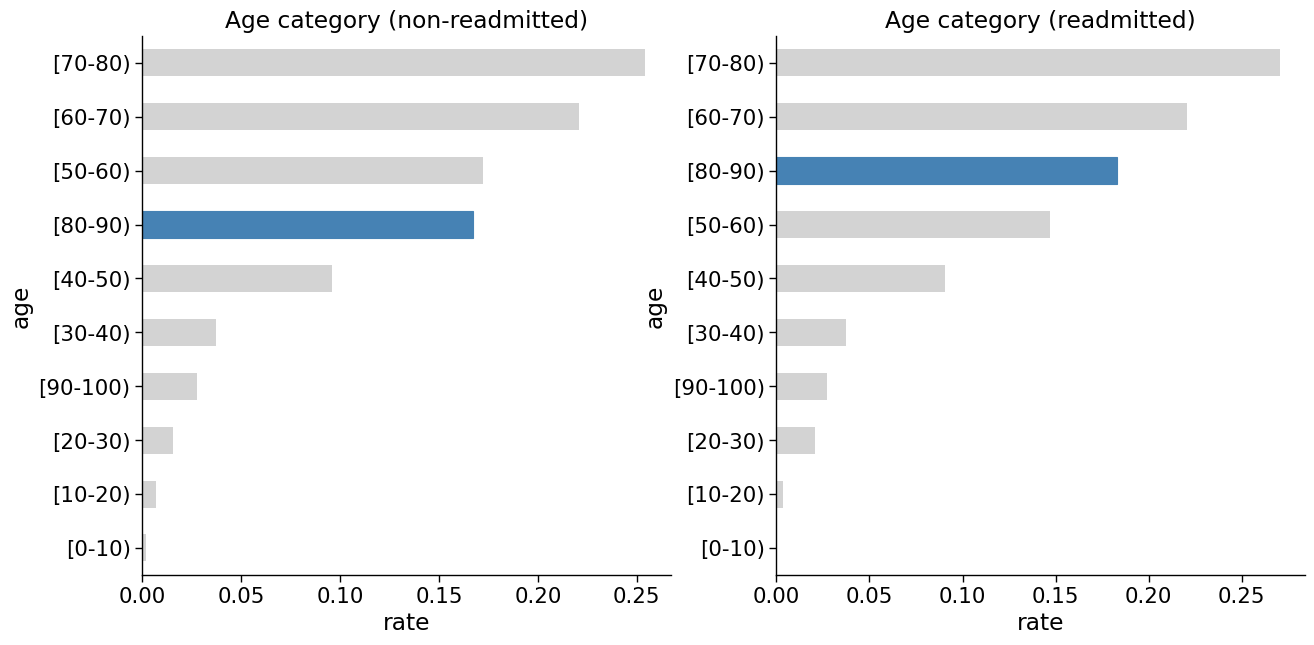

In [24]:
sns.set_context('paper', font_scale=1.75)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,7))

nonreadmitted_age.plot(kind="barh", title="Age category (non-readmitted)", color="lightgray", ax=ax1)
readmitted_age.plot(kind="barh", title="Age category (readmitted)", color="lightgray", ax=ax2)

ax1.set_xlabel("rate")
ax2.set_xlabel("rate")

ax1.patches[6].set_color("steelblue")
ax2.patches[7].set_color("steelblue")

sns.despine()

plt.savefig("/content/topage.png")
plt.show()

In the analysis, one should keep in mind than multiple factors drive readmission, independently from individuals being HbA1c tested or not

In [25]:
#Generate dummy variable being 1 when A1C tested
df2['A1C_tested'] = 1 - df2['A1Cresult'].isna()
df2['A1C_tested'].value_counts()

,count
A1C_tested,
0,58532
1,12986


In [ ]:
nontested_diag1 = df2[df2["A1C_tested"] != 1]["diag_1"] \
    .value_counts(ascending=True, normalize=True) \
    .tail(10)

nontested_diag1

,proportion
diag_1,
491,0.018437
780,0.019172
434,0.019667
427,0.029219
715,0.030244
486,0.034635
410,0.037609
786,0.040001
428,0.054371


In [ ]:
tested_diag1 = df2[df2["A1C_tested"] == 1]["diag_1"] \
    .value_counts(ascending=True, normalize=True) \
    .tail(10)

tested_diag1

,proportion
diag_1,
250.8,0.022491
780,0.023030
427,0.026419
486,0.031734
682,0.032812
434,0.033120
786,0.053840
410,0.053994
428,0.061465


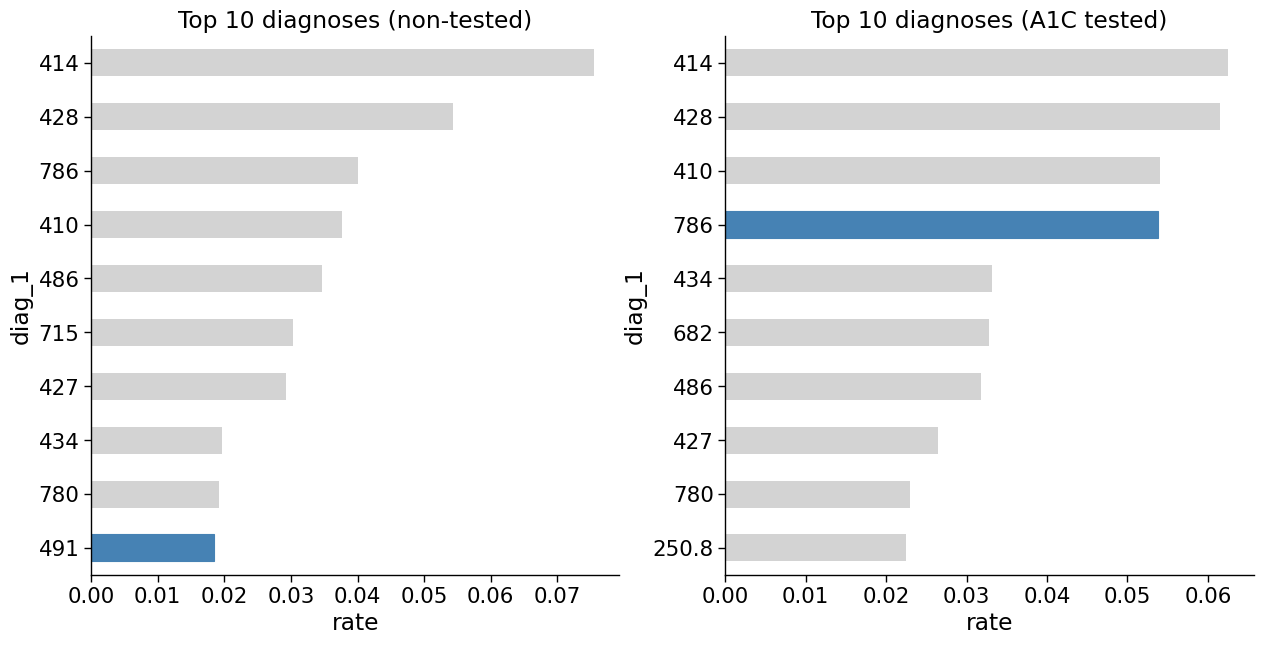

In [ ]:
sns.set_context('paper', font_scale=1.75)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,7))

nontested_diag1.plot(kind="barh", title="Top 10 diagnoses (non-tested)", color="lightgray", ax=ax1)
tested_diag1.plot(kind="barh", title="Top 10 diagnoses (A1C tested)", color="lightgray", ax=ax2)

ax1.set_xlabel("rate")
ax2.set_xlabel("rate")

#[TODO] change diagnoses in blue (find relevant ones)
ax1.patches[0].set_color("steelblue")
ax2.patches[6].set_color("steelblue")

#ax1.text(x=0.022,y=0-0.14,s="general symptoms")
#ax2.text(x=0.032,y=6-0.14,s="occlusion of cerebral arteries")

sns.despine()

plt.savefig("/content/top10diagnoses.png")
plt.show()

3. Data processing

[REFORMULATE] There were several
features that could not be treated directly since they had
a high percentage of missing values. These features were
weight (97% values missing), payer code (40%), and medical
specialty (47%). Weight attribute was considered to be too
sparse and it was not included in further analysis. Payer
code was removed since it had a high percentage of missing
values and it was not considered relevant to the outcome.
Medical specialty attribute was maintained, adding the value
“missing” in order to account for missing values.

In [ ]:
df2 = df2.drop(["encounter_id",
                "patient_nbr",
                "payer_code",
                "weight",
                "medical_specialty",
                "admission_source_id",
                "metformin",
                "glimepiride",
                "glipizide",
                "glyburide",
                "pioglitazone",
                "rosiglitazone",
                "insulin",
                "repaglinide",
                "nateglinide",
                "chlorpropamide",
                "acetohexamide",
                "tolbutamide",
                "acarbose",
                "miglitol",
                "troglitazone",
                "tolazamide",
                "examide",
                "citoglipton",
                "glyburide-metformin",
                "glipizide-metformin",
                "glimepiride-pioglitazone",
                "metformin-rosiglitazone",
                "metformin-pioglitazone",
                ], axis=1)

In [ ]:
df2.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'change',
       'diabetesMed', 'readmitted', 'A1C_tested'],
      dtype='object')

[REFORMULATE] Age \
The age group feature in this data set is categorical, but can be turned into an ordinal variable. That way we avoid creating too many new features after the one-hot encoding process.

In [ ]:
age_map = {'[0-10)': 0,
           '[10-20)': 1,
           '[20-30)': 2,
           '[30-40)': 3,
           '[40-50)': 4,
           '[50-60)': 5,
           '[60-70)': 6,
           '[70-80)': 7,
           '[80-90)': 8,
           '[90-100)': 9}

df2["age"].replace(age_map, inplace=True)

<ipython-input-21-6f6e985e54eb>:12: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



<ipython-input-21-6f6e985e54eb>:12: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



[REFORMULATE] Gender \
Gender will be converted to either 0 if male or 1 if female.

In [ ]:
df2["gender"] = df2["gender"].apply(lambda x: 1 if x == "Female" else 0)

[REFORMULATE] Admission type \
Group this feature by whether patients were admitted in an emergency or not. Thus, "Emergency" (which includes "Urgent") will become 1 and everything else will be 0.

In [ ]:
df2["emergency"] = df2["admission_type_id"].apply(lambda x: 1 if x in [1, 2] else 0)
df2.drop("admission_type_id", axis=1, inplace=True)

[REFORMULATE] Discharge disposition ID \
This feature has 29 distinct features, which would negatively impact the model's performance if we create dummy values for all of them. Therefore, I'm going to restrict these values to either "discharged to home" or other.

In [ ]:
df2["sent_home"] = df2["discharge_disposition_id"].apply(lambda x: 1 if x in [1, 6, 8] else 0)
df2.drop("discharge_disposition_id", axis=1, inplace=True)

[REFORMULATE] Diagnosis \
The diagnosis features are represented by ICD-9 codes. The idea here is to condensate the hundreds of codes into just a few major groups, based on field knowledge (Strack et al., 2014). I also made sure to include the diagnoses that were among the top 10 for readmitted patients but not for non-readmitted, and vice-versa.

In [ ]:
# Make it easier to enter ICD-9 ranges in the dictionary
interval = lambda x,y: list(range(x,y+1))

diag = {
    "Circulatory": interval(390, 433) + interval(435, 459) + [785],  # except 434
    "Respiratory": interval(460,519) + [786],
    "Digestive": interval(520,579) + [786],
    "Diabetes": [250],  # makes sense to give Diabetes a group for its own
    "Injury": interval(800,999),
    "Musculoskeletal": interval(710,739),
    "Genitourinary": interval(580,629) + [788],
    "Neoplasms": interval(140,239),
    "Endocrine": interval(240,249) + interval(251,279),  # except 250
    "General symptoms": [780,781,784] + interval(790,799),  # among thedupl top 10 for non-readmitted
    "Skin": interval(680,709) + [782],
    "Infection": interval(1,139),
    "Mental": interval(290,319),
    "External causes": [1000],  # passed by icd() as 1000, but the code doesn't exist officially
    "Blood": interval(280,289),
    "Nervous": interval(320,359),
    "Pregnancy": interval(630,679),
    "Sense organs": interval(360,389),
    "Congenital": interval(740, 759),
    "Occlusion of cerebral arteries": [434], # among the top 10 for readmitted
    "Unknown": [-1]
}

def icd(code):
    """Converts ICD-9 code in string format into a descriptive major category.
    ---
    code : int
    The ICD-9 encoded diagonisis

    return : str
    A major diagnostic category.
    """
    if (code[0] != "V") and (code[0] != "E"):
        code = floor(float(code))
    else:
        code = 1000
    for key in diag:
        if code in diag[key]:
            return key

In [ ]:
df2["diag_1"] = df2["diag_1"].fillna("-1").apply(icd)
df2["diag_2"] = df2["diag_2"].fillna("-1").apply(icd)
df2["diag_3"] = df2["diag_3"].fillna("-1").apply(icd)

[REFORMULATE] Glucose serum test result (max_glu_serum) and A1c test \
This variable indicates the range of the test results, or whether the tests were taken at all. It could be be converted into an ordinal variable and spare the creation of unnecessary dummy features.

In [ ]:
df2["A1Cresult"] = df2["A1Cresult"].map({"None": -1, "Norm": 0, ">7": 1, ">8": 2})
df2["max_glu_serum"] = df2["max_glu_serum"].map({"None": -1, "Norm": 0, ">200": 1, ">300": 2})

In [ ]:
df2["max_glu_serum_tested"] = df2["max_glu_serum"].apply(lambda x: 0 if x == -1 else 1)

Change of medication / Diabetes medications \
Converting object type to numerical:

In [ ]:
df2["change"] = df2["change"].apply(lambda x: 1 if x == "Ch" else 0)

In [ ]:
df2["diabetesMed"] = df2["diabetesMed"].apply(lambda x: 1 if x == "Yes" else 0)

Readmitted (target variable)
Setting the variable to 1 if readmitted earlier than 30 days, 0 otherwise.

In [ ]:
df2['readmitted'] = df2['readmitted'].apply(lambda x: 1 if x == "<30" else 0)

Dummy variables creation
All categorical variables are going to be converted into dummy variables (one-hot encoding).

In [ ]:
df2 = pd.get_dummies(df2, dummy_na=False, drop_first=False)

In [ ]:
#for disease in diag:
#    df2[f"diag_{disease}"] = df2[f"diag_1_{disease}"]*3 + df2[f"diag_2_{disease}"]*2 + df2[f"diag_3_{disease}"]*1
#    df2.drop([f"diag_{n}_{disease}" for n in range(1,4)], axis=1, inplace=True)

In [ ]:
df2.columns

Index(['gender', 'age', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'change', 'diabetesMed', 'readmitted',
       'A1C_tested', 'emergency', 'sent_home', 'max_glu_serum_tested',
       'race_AfricanAmerican', 'race_Asian', 'race_Caucasian', 'race_Hispanic',
       'race_Other', 'diag_1_Blood', 'diag_1_Circulatory', 'diag_1_Congenital',
       'diag_1_Diabetes', 'diag_1_Digestive', 'diag_1_Endocrine',
       'diag_1_External causes', 'diag_1_General symptoms',
       'diag_1_Genitourinary', 'diag_1_Infection', 'diag_1_Injury',
       'diag_1_Mental', 'diag_1_Musculoskeletal', 'diag_1_Neoplasms',
       'diag_1_Nervous', 'diag_1_Occlusion of cerebral arteries',
       'diag_1_Pregnancy', 'diag_1_Respiratory', 'diag_1_Sense organs',
       'diag_1_Skin', 'diag_1_Unknown', 'diag_2_Blood', 'diag_2_Circulatory',
       'diag_2_

TODO: add correlation of DiabMed & HbA1c test/results

In [ ]:
abscorr = df2.corr().abs()
corr_list = abscorr.unstack().sort_values(kind="quicksort", ascending=False)
corr_list[(corr_list > 0.5) & (corr_list != 1)]

,,0
race_Caucasian,race_AfricanAmerican,0.807590
race_AfricanAmerican,race_Caucasian,0.807590
diag_1_Pregnancy,diag_2_Pregnancy,0.768226
diag_2_Pregnancy,diag_1_Pregnancy,0.768226
diag_1_Pregnancy,diag_3_Pregnancy,0.678531
diag_3_Pregnancy,diag_1_Pregnancy,0.678531
diabetesMed,change,0.506697
change,diabetesMed,0.506697


In [ ]:
df2.columns

Index(['gender', 'age', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'change', 'diabetesMed', 'readmitted',
       'A1C_tested', 'emergency', 'sent_home', 'max_glu_serum_tested',
       'race_AfricanAmerican', 'race_Asian', 'race_Caucasian', 'race_Hispanic',
       'race_Other', 'diag_1_Blood', 'diag_1_Circulatory', 'diag_1_Congenital',
       'diag_1_Diabetes', 'diag_1_Digestive', 'diag_1_Endocrine',
       'diag_1_External causes', 'diag_1_General symptoms',
       'diag_1_Genitourinary', 'diag_1_Infection', 'diag_1_Injury',
       'diag_1_Mental', 'diag_1_Musculoskeletal', 'diag_1_Neoplasms',
       'diag_1_Nervous', 'diag_1_Occlusion of cerebral arteries',
       'diag_1_Pregnancy', 'diag_1_Respiratory', 'diag_1_Sense organs',
       'diag_1_Skin', 'diag_1_Unknown', 'diag_2_Blood', 'diag_2_Circulatory',
       'diag_2_

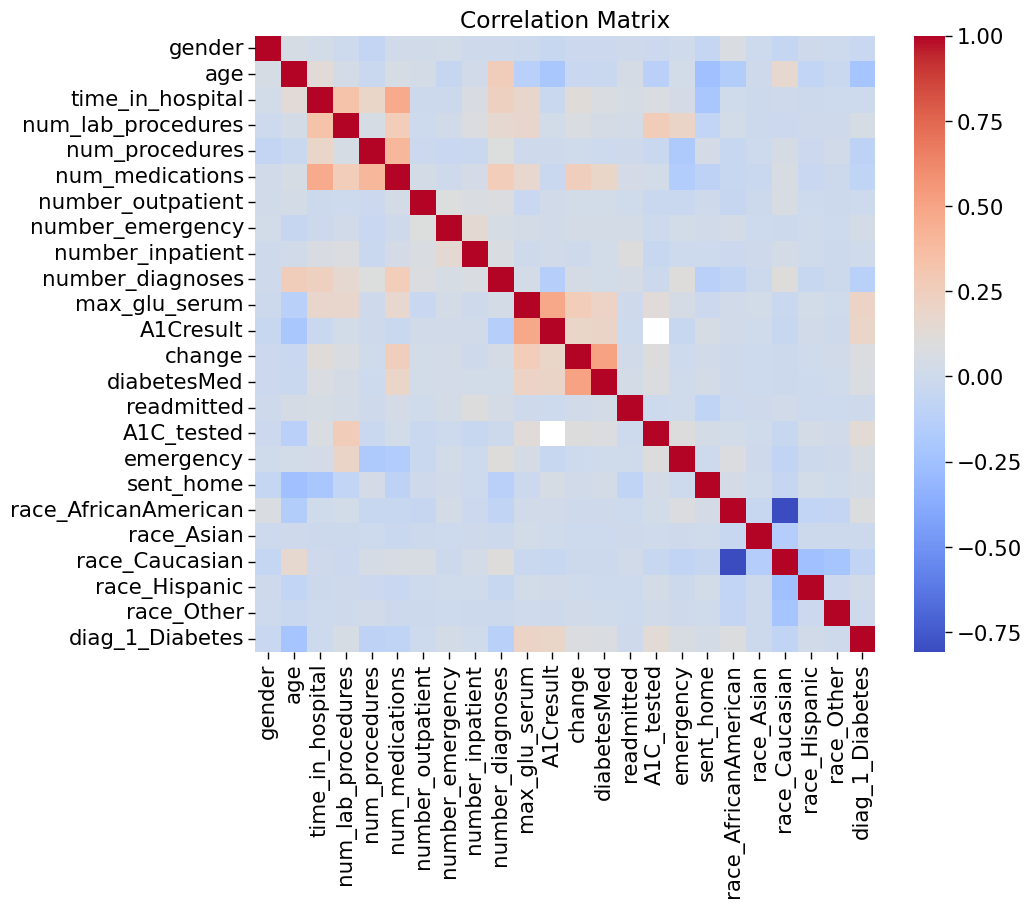

In [ ]:
variables = ['gender', 'age', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'change', 'diabetesMed', 'readmitted',
       'A1C_tested', 'emergency', 'sent_home',
       'race_AfricanAmerican', 'race_Asian', 'race_Caucasian', 'race_Hispanic',
       'race_Other', 'diag_1_Diabetes']

correlation_matrix = df2[variables].corr()
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

4. Model for impact evaluation

In [ ]:
# Define target variable and features space.
y = df2['readmitted'].values
X = df2.drop("readmitted", axis=1).values

# 75/25 split of the data into training/test sets.
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

TODO General idea: The goal here is to demonstrate that, compared to "control" individuals (e.g., those with the same likelihood of having diabetes), individuals who underwent the HbA1c test are less likely to be readmitted. This suggests that the test may lead to more accurate diagnoses and better management of the condition.


TODO: https://medium.com/@med.hmamouch99/double-machine-learning-for-causal-inference-a-practical-guide-5d85b77aa586

[TO CHECK, REFORMULATE] Additionally, we removed all encounters that resulted
in either discharge to a hospice or patient death, to avoid
biasing our analysis.

TODO: variable selection, The variables chosen to control for patient demographic
and illness severity were gender, age, race, admission source,
discharge disposition, primary diagnosis (see Table 2), medical
specialty of the admitting physician, and time spent in
hospital

[PAPER METHOD] Multivariable logistic regression was used to fit the
relationship between the measurement of HbA1c and early
readmission while controlling for covariates such as demographics,
severity and type of the disease, and type of
admission.